In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the VAE class using Convolutional layers
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder network (CNN)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # 32x32x3 -> 16x16x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 16x16x32 -> 8x8x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 8x8x64 -> 4x4x128
        self.fc1 = nn.Linear(128*4*4, 512)
        self.fc2_mu = nn.Linear(512, latent_dim)  # For mean
        self.fc2_logvar = nn.Linear(512, latent_dim)  # For log-variance
        
        # Decoder network (CNN)
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 128*4*4)
        self.conv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 4x4x128 -> 8x8x64
        self.conv5 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 8x8x64 -> 16x16x32
        self.conv6 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)  # 16x16x32 -> 32x32x3
        
    def encode(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(h1))
        h3 = F.relu(self.conv3(h2))
        h3_flat = h3.view(h3.size(0), -1)  # Flatten the feature map
        h4 = F.relu(self.fc1(h3_flat))
        mu = self.fc2_mu(h4)
        logvar = self.fc2_logvar(h4)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # standard deviation
        eps = torch.randn_like(std)  # random noise
        z = mu + eps*std  # sample from N(mu, sigma^2)
        return z
    
    def decode(self, z):
        h5 = F.relu(self.fc3(z))
        h6 = F.relu(self.fc4(h5))
        h6_reshaped = h6.view(h6.size(0), 128, 4, 4)
        h7 = F.relu(self.conv4(h6_reshaped))
        h8 = F.relu(self.conv5(h7))
        x_reconstructed = torch.sigmoid(self.conv6(h8))  # Using sigmoid to constrain the output between 0 and 1
        return x_reconstructed
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar



In [5]:
# Define the VAE loss function (using MSELoss instead of BCE)
def vae_loss(x_reconstructed, x, mu, logvar):
    # Reconstruction loss (Mean Squared Error)
    MSE = F.mse_loss(x_reconstructed, x, reduction='sum')
    
    # KL divergence loss
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total VAE loss
    return MSE + KL_div
# Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])



In [14]:

# Download CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# Create the VAE model
latent_dim = 20
model = VAE(latent_dim)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
def train_vae(model, train_loader, optimizer, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        train_loss = 0
        for data, _ in train_loader:
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, mu, logvar = model(data)
            
            # Compute loss
            loss = vae_loss(reconstructed, data, mu, logvar)
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            train_loss += loss.item()
        
        # Print the average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset)}")



100%|██████████| 170M/170M [00:21<00:00, 8.02MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data


In [13]:
# Start training
train_vae(model, train_loader, optimizer, num_epochs=10)

RuntimeError: output with shape [1, 28, 28] doesn't match the broadcast shape [3, 28, 28]

In [8]:
# Start training
train_vae(model, train_loader, optimizer, num_epochs=10)

Epoch [1/10], Loss: 538.9394563574218
Epoch [2/10], Loss: 538.2353040039062
Epoch [3/10], Loss: 537.6349412890625
Epoch [4/10], Loss: 537.1351985449219
Epoch [5/10], Loss: 536.681393515625
Epoch [6/10], Loss: 536.2931744140625
Epoch [7/10], Loss: 535.8672916796875
Epoch [8/10], Loss: 535.5696532226563
Epoch [9/10], Loss: 535.2271116992188
Epoch [10/10], Loss: 534.9387535839844


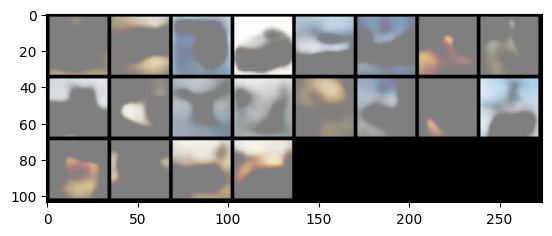

In [11]:
import matplotlib.pyplot as plt
import torch
import torchvision

# 生成新的图像
def generate_images(model, num_images=10):
    model.eval()  # Set model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 随机从标准正态分布中采样
    model.to(device)
    z = torch.randn(num_images, model.latent_dim).to(device)
    
    # 通过解码器生成图像
    with torch.no_grad():
        generated_images = model.decode(z)
    
    # 将输出从[-1, 1]的范围恢复到[0, 1]的范围（如果进行了归一化）
    generated_images = generated_images * 0.5 + 0.5
    
    # 显示生成的图像
    grid_img = torchvision.utils.make_grid(generated_images)
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.show()

# 调用生成函数，生成10张新的图像
generate_images(model, num_images=20)
